# Bayesian Logistic Regression

In this notebook we reproduce the Logistic Regression example, but by directly leveraging the fact that the prior is Gaussian to use the latent Gaussian model. Most of the code is the same as in the previous notebook, but the sampler (and the adaptation step) will differ.

In [1]:
import jax
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt
from sklearn.datasets import make_biclusters

import blackjax

In [2]:
% config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["figure.figsize"] = (12, 8)

UsageError: Line magic function `%` not found.


In [3]:
% load_ext watermark
% watermark -d -m -v -p jax, jaxlib, blackjax

UsageError: Line magic function `%` not found.


## The data

We create two clusters of points using [scikit-learn's `make_bicluster` function](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_biclusters.html?highlight=bicluster%20data#sklearn.datasets.make_biclusters).

In [4]:
num_points = 50
X, rows, cols = make_biclusters(
    (num_points, 2), 2, noise=0.6, random_state=314, minval=-3, maxval=3
)
y = rows[0] * 1.0  # y[i] = whether point i belongs to cluster 1

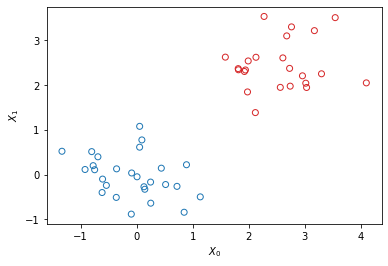

In [5]:
colors = ["tab:red" if el else "tab:blue" for el in rows[0]]
plt.scatter(*X.T, edgecolors=colors, c="none")
plt.xlabel(r"$X_0$")
plt.ylabel(r"$X_1$")
plt.show()

## The model

We use a simple logistic regression model to infer to which cluster each of the points belongs. We note $y$ a binary variable that indicates whether a point belongs to the first cluster :

$$
y \sim \operatorname{Bernoulli}(p)
$$

The probability $p$ to belong to the first cluster commes from a logistic regression:

$$
p = \operatorname{logistic}(\Phi\,\boldsymbol{w})
$$

where $w$ is a vector of weights whose priors are a normal prior centered on 0:

$$
\boldsymbol{w} \sim \operatorname{Normal}(0, \sigma)
$$

And $\Phi$ is the matrix that contains the data, so each row $\Phi_{i,:}$ is the vector $\left[1, X_0^i, X_1^i\right]$

In [6]:
Phi = jnp.c_[jnp.ones(num_points)[:, None], X]
N, M = Phi.shape
alpha = 1.0
C = jnp.eye(M) / alpha  # covariance of the prior for the weights


def sigmoid(z):
    return jnp.exp(z) / (1 + jnp.exp(z))


def log_sigmoid(z):
    return z - jnp.log(1 + jnp.exp(z))


def log_likelihood(w):
    """The log-probability density function of the posterior distribution of the model."""
    log_an = log_sigmoid(Phi @ w)
    an = Phi @ w
    log_likelihood_term = y * log_an + (1 - y) * jnp.log(1 - sigmoid(an))

    return log_likelihood_term.sum()

## Posterior sampling

We use `blackjax`'s Random Walk RMH kernel to sample from the posterior distribution.

In [7]:
rng_key = random.PRNGKey(314)

w0 = jnp.zeros((M,))

init, step = blackjax.mgrad_gaussian(log_likelihood, C)
initial_state = init(w0)

We first define a calibration loop. The goal is to find the "step-size" `delta` that approximately corresponds to an acceptance probability of 0.5.


In [62]:
def calibration_loop(
    rng_key,
    initial_state,
    initial_delta,
    num_steps,
    update_every=100,
    target=0.5,
    rate=0.5,
):
    def body(carry):
        i, state, delta, pct_accepted, rng_key = carry
        rng_key, rng_key2 = jax.random.split(rng_key, 2)
        state, info = step(rng_key, state, delta)

        # restart calibration of delta
        j = i % update_every
        pct_accepted = (j * pct_accepted + info.is_accepted) / (j + 1)
        diff = target - pct_accepted
        delta = jax.lax.cond(
            j == 0, lambda _: delta * (1 - diff * rate), lambda _: delta, None
        )

        return i + 1, state, delta, pct_accepted, rng_key2

    _, final_state, final_delta, final_pct_accepted, _ = jax.lax.while_loop(
        lambda carry: carry[0] < num_steps,
        body,
        (0, initial_state, initial_delta, 0.0, rng_key),
    )

    return final_state, final_delta


def inference_loop(rng_key, initial_delta, initial_state, num_samples, num_burnin):
    rng_key, rng_key2 = jax.random.split(rng_key, 2)

    initial_state, delta = calibration_loop(
        rng_key, initial_state, initial_delta, num_burnin
    )

    @jax.jit
    def one_step(carry, rng_key):
        i, pct_accepted, state = carry
        state, info = step(rng_key, state, delta)
        pct_accepted = (i * pct_accepted + info.is_accepted) / (i + 1)
        return (i + 1, pct_accepted, state), state

    keys = jax.random.split(rng_key, num_samples)
    (_, tota_pct_accepted, _), states = jax.lax.scan(
        one_step, (0, 0.0, initial_state), keys
    )
    return states, tota_pct_accepted

We can now run the inference:

In [65]:
_, rng_key = random.split(rng_key)
states, tota_pct_accepted = inference_loop(rng_key, 0.5, initial_state, 5_000, 1_000)
print(f"Percentage of accepted samples (after calibration): {tota_pct_accepted:.2%}")

Percentage of accepted samples (after calibration): 47.36%


And display the trace:

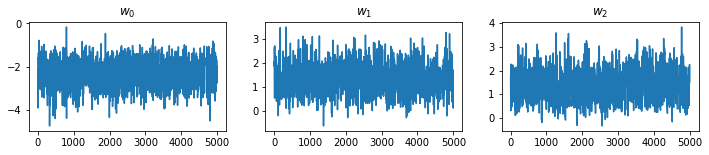

In [67]:
fig, ax = plt.subplots(1, 3, figsize=(12, 2))
for i, axi in enumerate(ax):
    axi.plot(states.x[:, i])
    axi.set_title(f"$w_{i}$")
plt.show()

In [69]:
chains = states.x
nsamp, _ = chains.shape

### Predictive distribution

Having infered the posterior distribution of the regression's coefficients we can compute the probability to belong to the first cluster at each position $(X_0, X_1)$.

In [70]:
# Create a meshgrid
xmin, ymin = X.min(axis=0) - 0.1
xmax, ymax = X.max(axis=0) + 0.1
step = 0.1
Xspace = jnp.mgrid[xmin:xmax:step, ymin:ymax:step]
_, nx, ny = Xspace.shape

# Compute the average probability to belong to the first cluster at each point on the meshgrid
Phispace = jnp.concatenate([jnp.ones((1, nx, ny)), Xspace])
Z_mcmc = sigmoid(jnp.einsum("mij,sm->sij", Phispace, chains))
Z_mcmc = Z_mcmc.mean(axis=0)

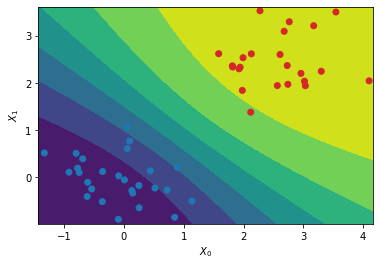

In [71]:
plt.contourf(*Xspace, Z_mcmc)
plt.scatter(*X.T, c=colors)
plt.xlabel(r"$X_0$")
plt.ylabel(r"$X_1$")
plt.show()

We essentially recover the same contours as with the standard random walk approach.